# Adversarial Generative Network

The intention of this notebook is to create a GAN to generate realistic handwritten digest from the MNIST dataset.

In [1]:
import datetime
import math

import matplotlib.pyplot as plt
import numpy as np
import sklearn.metrics
import seaborn as sns
import tensorflow as tf
from tqdm import tqdm_notebook

from utils.mnist_dataset import MNIST_Dataset
from utils.batch import make_batches_all, make_batches_random

In [2]:
assert(int(tf.__version__[0])==2)  # Use TensorFlow 2

In [3]:
%load_ext tensorboard

In [4]:
# Check computing units
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 12645307612313591415, name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 7489745787565532250
 physical_device_desc: "device: XLA_GPU device", name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 12441636758566095690
 physical_device_desc: "device: XLA_CPU device", name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 7511012148
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 13580493410320398187
 physical_device_desc: "device: 0, name: Tesla M60, pci bus id: 0000:00:1e.0, compute capability: 5.2"]

## Constants

In [5]:
LOG_PATH = 'log-GAN'  # For tensorboard, etc.

DS_PATH = 'data' # Where de MNIST dataset is located

# Hyperparams
PARAMS = {
    'generator': {
        'learning_rate': 0.00001
    },
    'discriminator': {
        'learning_rate': 0.00001
    },
    'latent_factors': 100,
    'epochs': 200,
    'batch_size': 64,  # Use an even number
    'disc_gen_ratio': 1  # How many times over the generator the discriminator is trained.
}

## Dataset

In [6]:
!bash download_mnist.sh {DS_PATH}

In [7]:
class Dataset():
        
    def __init__(self, ds_path):
        self.ds = MNIST_Dataset(ds_path)
        
    @staticmethod
    def _preprocess_samples(x):
        """x: tensor of shape (-1, 28, 28) representing the images.
        """
        n,w,h = x.shape
        # From 28x28 pixels to 32x32
        x_32 = np.pad(
            x,
            pad_width=((0,0),(2,2),(2,2)),
            mode='constant',
            constant_values=0
        )
        x_scaled = (x_32/128)-1 # Scaled -1,1
        return x_scaled.reshape(n,32,32,1)
    
    
    def train_data(self):
        x,y = self.ds.get_train()
        return (
            self._preprocess_samples(x).astype(np.float32),
            y
        )

## Model architecture

### Generator

This model tries to generate realistic images.
-  INPUT: Noise vector (1x100).
-  OUTPUT: Image (32x32)

In [8]:
def get_generator(latent_factors):
    """ From noise to plausible examples.
    INPUT: Noise vector of latent factors (-1,1)
    OUTPUT: 32x32x1 (-1,1) grayscale image
    """
    return tf.keras.Sequential(
        name="Generator",
        layers=[
            tf.keras.layers.InputLayer(
                input_shape=(latent_factors)
            ),
            tf.keras.layers.Dense(  
                name="D1",
                units=128,
                activation=tf.keras.layers.LeakyReLU(alpha=0.2)
            ),
            tf.keras.layers.Dense(  
                name="D2",
                units=256,
                activation=tf.keras.layers.LeakyReLU(alpha=0.2)
            ),
            tf.keras.layers.Dense(  
                name="D3",
                units=512,
                activation=tf.keras.layers.LeakyReLU(alpha=0.2)
            ),
            tf.keras.layers.BatchNormalization(
                momentum=0.8,
                name="BN1"
            ),
            tf.keras.layers.Dense(  
                name="D4",
                units=1024,
                activation=tf.math.tanh
            ),
            # Reshape 120->1x1x120
            tf.keras.layers.Reshape(
                target_shape=(32,32,1)
            )
        ]
    )

### Discriminator

This model tells the image probability of being real.
-  INPUT: Image (32x32).
-  OUTPUT: Probability (0,1)

In [9]:
def get_discriminator():
    """Output the probability for an example to be real.
    """
    return tf.keras.Sequential(
        name="Discriminator",
        layers=[
            tf.keras.layers.InputLayer(
                input_shape=(32,32,1)
            ),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(  
                name="F3",
                units=512,
                activation=tf.keras.layers.LeakyReLU(alpha=0.2)
            ),
            tf.keras.layers.Dense(  
                name="F4",
                units=256,
                activation=tf.keras.layers.LeakyReLU(alpha=0.2)
            ),
            tf.keras.layers.Dense(  
                name="F5",
                units=1,
                activation=tf.math.sigmoid
            )
        ]
    )

### Generative Adversarial Network

This model represents the pipeline of the GAN.

In [10]:
def get_gan(generator, discriminator):
    return tf.keras.Sequential(
        name="GAN",
        layers=[
            tf.keras.layers.InputLayer(
                input_shape=(
                    generator.layers[0].input.shape[1]
                )
            ),
            generator,
            discriminator
        ]
    )

### Model objects

In [11]:
generator = get_generator(PARAMS['latent_factors'])
gen_opt = tf.keras.optimizers.Adam(
    learning_rate=PARAMS['generator']['learning_rate']
)

discriminator = get_discriminator()
disc_opt = tf.keras.optimizers.Adam(
    learning_rate=PARAMS['discriminator']['learning_rate']
)

gan = get_gan(generator, discriminator)

generator.summary()
discriminator.summary()
gan.summary()

Model: "Generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
D1 (Dense)                   (None, 128)               12928     
_________________________________________________________________
D2 (Dense)                   (None, 256)               33024     
_________________________________________________________________
D3 (Dense)                   (None, 512)               131584    
_________________________________________________________________
BN1 (BatchNormalization)     (None, 512)               2048      
_________________________________________________________________
D4 (Dense)                   (None, 1024)              525312    
_________________________________________________________________
reshape (Reshape)            (None, 32, 32, 1)         0         
Total params: 704,896
Trainable params: 703,872
Non-trainable params: 1,024
_______________________________________________

## Util Functions

In [12]:
def sample_latent_factors(n):
    """Noise sample function.
    """
    return tf.random.uniform(shape=(n, PARAMS['latent_factors']), minval=-1.0, maxval=1.0)  # Naive way.
    #return tf.random.normal(shape=(n, PARAMS['latent_factors']), mean=0.0, stddev=1.0)

In [13]:
def plot_generated_images(epoch, images, path_out, dim=(10,10), figsize=(32,32)):
    epoch = str(epoch).rjust(3,"0")
    generated_images = images.reshape(-1,32,32)
    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generated_images[i], interpolation='nearest', cmap='gray')
        plt.axis('off')
    plt.tight_layout()
    plt.suptitle('Epoch: {}'.format(epoch), fontsize=75, horizontalalignment='center', verticalalignment='top', backgroundcolor="black", color='yellow', weight='bold')
    plt.savefig(path_out + '/generator_{}.png'.format(epoch))
    plt.close()
    return None

## Operative

In [14]:
def train_step(model, optimizer, fn_loss, x_train, y_train):
    """Training step for a model.
    """
    with tf.GradientTape() as tape:
        predictions = model(x_train, training=True)
        loss = fn_loss(y_train, predictions)
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    return loss

In [15]:
def fn_loss(y_true, y_pred):
    """Loss function.
    Log loss or cross-entropy.
    
    NOTE: it is possible to use tf.keras.losses.BinaryCrossentropy() alone.
    param reduction='SUM_OVER_BATCH_SIZE'  works the same.
    """
    return tf.math.reduce_mean(
        tf.keras.losses.binary_crossentropy(
            y_true=y_true,
            y_pred=y_pred,
            label_smoothing = 0,  # Not useful since I only need one sided label smoothing
            from_logits=False
        )
    )

In [16]:
# Tensorboard writers

log_dir = LOG_PATH + '/' + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
gen_summary_writer = tf.summary.create_file_writer(log_dir + '/gen')
disc_summary_writer = tf.summary.create_file_writer(log_dir + '/disc')

img_out_dir = log_dir + '/imgs'

In [17]:
!mkdir {img_out_dir}

In [18]:
# Load the dataset

ds = Dataset(DS_PATH)
x_real, _ = ds.train_data()  # I don't care about labels

In [19]:
# Precalculate batch labels to gain speed.

bs = PARAMS['batch_size']
n_batches = math.ceil(len(x_real)*2 / bs) # Real + Fake data / batch_size

# Discriminator labels
disc_y = tf.concat(
    [
        tf.fill((bs//2,1), 0.95), # Real. One sided label smoothing
        tf.fill((bs//2,1), 0.0)   # Fake
    ],
    axis=0
)

# Generator labels
gen_y = tf.fill((bs,1), 1.0)  # Do not smooth generator samples!!

assert(len(disc_y)==len(gen_y))

In [20]:
def evaluate(generator, discriminator, val_data_real, val_data_fake):
    n = len(val_data_real)
    y_true = tf.concat([tf.fill((n,1), 1.0),tf.fill((n,1), 0.0)], axis=0)
    y_pred = discriminator( tf.concat([val_data_real, val_data_fake ],axis=0) )
    y_true_bin = y_true.numpy().flatten()
    y_pred_bin = np.where(y_pred.numpy().flatten()>=0.5, 1, 0)

    # Metrics
    cf = sklearn.metrics.confusion_matrix(y_true, y_pred_bin)
    tn, fp, fn, tp = cf.ravel()
    return {
        'disc_loss': fn_loss(y_true, y_pred),
        'gen_loss': fn_loss(tf.fill((n,1), 1.0), discriminator(val_data_fake)),
        'acc': sklearn.metrics.accuracy_score(y_true, y_pred_bin),
        'fpr': fp/(fp+tn), # False positive ratio
        'cm': cf
    }

## Training

### Tensorboard

We will track the metrics evolution and the generated images with Tensorboard.

In [ ]:
%tensorboard --logdir {log_dir}

### Taining loop

In [22]:
""" Training loop.

Use tensorboard to see examples and what is happening.


"""

# Generator for real data, random sampling strategy
x_real_g=make_batches_random(
    x=x_real,
    y=None,
    batch_size=bs//2,
    stop_after_epoch=False
)

# Validation data
val_data_real=np.take(  # Real samples
    a=x_real,
    indices=np.random.randint(
        low=0,
        high=len(x_real), 
        size=256
    ),
    axis=0
)
val_params_fake = sample_latent_factors(256)


for epoch in range(0, PARAMS['epochs']):  
    # Batch
    with tqdm_notebook(total=n_batches, unit='batch', desc="Epoch: {} ".format(epoch)) as pbar:
        for n_batch in range(n_batches):
            for i in range(PARAMS['disc_gen_ratio']):
                # DISCRIMINATOR
                _, disc_x_real, _ = x_real_g.__next__()
                disc_x = tf.concat([
                    disc_x_real,
                    generator(sample_latent_factors(bs//2))  # Fake data
                ], axis=0)
                discriminator.trainable=True
                disc_b_loss = train_step(
                    model=discriminator,
                    optimizer=disc_opt,
                    fn_loss=fn_loss,
                    x_train=disc_x,
                    y_train=disc_y
                )    
            # GENERATOR
            discriminator.trainable=False
            gen_b_loss = train_step(
                model=gan,  # Latent params -> Generator -> image -> Discriminator -> Probability
                optimizer=gen_opt,
                fn_loss=fn_loss,
                x_train=sample_latent_factors(bs),
                y_train=gen_y
            )

            #Update progress bar
            pbar.set_postfix(disc_loss=disc_b_loss.numpy(), gen_loss=gen_b_loss.numpy())
            pbar.update(1)

        
    # EPOCH METRICS
    val_data_fake = generator(val_params_fake)
    val_metrics = evaluate(generator, discriminator, val_data_real, val_data_fake)
    for m in ['disc_loss','acc','gen_loss','fpr','cm']:
        print("{}\t{}".format(m, val_metrics[m]))
    
    with disc_summary_writer.as_default():
        tf.summary.scalar('loss', val_metrics["disc_loss"], step=epoch)
        tf.summary.scalar('acc', val_metrics["acc"], step=epoch)
    with gen_summary_writer.as_default():
        tf.summary.scalar('loss', val_metrics["gen_loss"], step=epoch)
        tf.summary.scalar('fpr', val_metrics["fpr"], step=epoch)
        tf.summary.image("Training data", val_data_fake, step=epoch, max_outputs=25)
    
    if epoch%2 == 0:
        plot_generated_images(epoch, val_data_fake.numpy()[:100], img_out_dir) # Output generated images   

W0611 11:50:56.157021 140477169415936 deprecation.py:323] From /home/ubuntu/ai_tests/tf/tf2/venv/lib/python3.5/site-packages/tensorflow/python/ops/math_grad.py:1220: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



disc_loss	0.046386756002902985
acc	1.0
gen_loss	3.3935108184814453
fpr	0.0
cm	[[256   0]
 [  0 256]]



disc_loss	0.06313662230968475
acc	1.0
gen_loss	3.039912700653076
fpr	0.0
cm	[[256   0]
 [  0 256]]



disc_loss	0.07350130379199982
acc	0.998046875
gen_loss	2.7664241790771484
fpr	0.0
cm	[[256   0]
 [  1 255]]



disc_loss	0.04077740013599396
acc	1.0
gen_loss	4.070962905883789
fpr	0.0
cm	[[256   0]
 [  0 256]]



disc_loss	0.047758907079696655
acc	1.0
gen_loss	3.7959330081939697
fpr	0.0
cm	[[256   0]
 [  0 256]]



disc_loss	0.11347033083438873
acc	0.998046875
gen_loss	2.190279960632324
fpr	0.0
cm	[[256   0]
 [  1 255]]



disc_loss	0.34108030796051025
acc	0.939453125
gen_loss	1.2892963886260986
fpr	0.0
cm	[[256   0]
 [ 31 225]]



disc_loss	0.5267029404640198
acc	0.861328125
gen_loss	0.9960399866104126
fpr	0.0
cm	[[256   0]
 [ 71 185]]



disc_loss	0.6380903124809265
acc	0.78515625
gen_loss	0.9217107892036438
fpr	0.0
cm	[[256   0]
 [110 146]]



disc_loss	0.6792364120483398
acc	0.51171875
gen_loss	0.662309467792511
fpr	0.61328125
cm	[[ 99 157]
 [ 93 163]]



disc_loss	0.6810466051101685
acc	0.677734375
gen_loss	0.7670036554336548
fpr	0.25
cm	[[192  64]
 [101 155]]



disc_loss	0.7023062705993652
acc	0.7109375
gen_loss	0.9008906483650208
fpr	0.0078125
cm	[[254   2]
 [146 110]]



disc_loss	0.7305512428283691
acc	0.603515625
gen_loss	0.7550332546234131
fpr	0.3203125
cm	[[174  82]
 [121 135]]



disc_loss	0.6952733993530273
acc	0.662109375
gen_loss	0.786998987197876
fpr	0.234375
cm	[[196  60]
 [113 143]]



disc_loss	0.6311920881271362
acc	0.7421875
gen_loss	0.9495234489440918
fpr	0.01171875
cm	[[253   3]
 [129 127]]



disc_loss	0.668420135974884
acc	0.642578125
gen_loss	0.8194564580917358
fpr	0.24609375
cm	[[193  63]
 [120 136]]



disc_loss	0.7070040702819824
acc	0.59765625
gen_loss	0.7750905752182007
fpr	0.38671875
cm	[[157  99]
 [107 149]]



disc_loss	0.6801555752754211
acc	0.6640625
gen_loss	0.9401624798774719
fpr	0.08203125
cm	[[235  21]
 [151 105]]



disc_loss	0.6999139189720154
acc	0.650390625
gen_loss	0.8885772228240967
fpr	0.1875
cm	[[208  48]
 [131 125]]



disc_loss	0.6887761354446411
acc	0.662109375
gen_loss	0.8800946474075317
fpr	0.140625
cm	[[220  36]
 [137 119]]



disc_loss	0.751849889755249
acc	0.591796875
gen_loss	0.8493560552597046
fpr	0.22265625
cm	[[199  57]
 [152 104]]



disc_loss	0.7144362330436707
acc	0.515625
gen_loss	0.6692614555358887
fpr	0.6015625
cm	[[102 154]
 [ 94 162]]



disc_loss	0.6607401371002197
acc	0.603515625
gen_loss	0.6986883878707886
fpr	0.47265625
cm	[[135 121]
 [ 82 174]]



disc_loss	0.7098118662834167
acc	0.544921875
gen_loss	0.6800804734230042
fpr	0.578125
cm	[[108 148]
 [ 85 171]]



disc_loss	0.6818139553070068
acc	0.58984375
gen_loss	0.7513629198074341
fpr	0.40625
cm	[[152 104]
 [106 150]]



disc_loss	0.6541136503219604
acc	0.716796875
gen_loss	0.8579651713371277
fpr	0.1328125
cm	[[222  34]
 [111 145]]



disc_loss	0.6972728967666626
acc	0.6015625
gen_loss	0.8799139857292175
fpr	0.203125
cm	[[204  52]
 [152 104]]



disc_loss	0.7271852493286133
acc	0.603515625
gen_loss	0.8113257884979248
fpr	0.2265625
cm	[[198  58]
 [145 111]]



disc_loss	0.7006211280822754
acc	0.556640625
gen_loss	0.7272056937217712
fpr	0.4375
cm	[[144 112]
 [115 141]]



disc_loss	0.7472083568572998
acc	0.4765625
gen_loss	0.6957739591598511
fpr	0.5390625
cm	[[118 138]
 [130 126]]



disc_loss	0.701326310634613
acc	0.552734375
gen_loss	0.7401108741760254
fpr	0.44140625
cm	[[143 113]
 [116 140]]



disc_loss	0.7020282745361328
acc	0.60546875
gen_loss	0.8310145735740662
fpr	0.23828125
cm	[[195  61]
 [141 115]]



disc_loss	0.6322099566459656
acc	0.685546875
gen_loss	0.8515848517417908
fpr	0.19921875
cm	[[205  51]
 [110 146]]



disc_loss	0.6839138269424438
acc	0.59765625
gen_loss	0.7960038185119629
fpr	0.296875
cm	[[180  76]
 [130 126]]



disc_loss	0.6976467370986938
acc	0.62890625
gen_loss	0.91874098777771
fpr	0.08984375
cm	[[233  23]
 [167  89]]



disc_loss	0.7238335013389587
acc	0.560546875
gen_loss	0.8171689510345459
fpr	0.25390625
cm	[[191  65]
 [160  96]]



disc_loss	0.6994589567184448
acc	0.625
gen_loss	0.8870992064476013
fpr	0.15625
cm	[[216  40]
 [152 104]]



disc_loss	0.6664563417434692
acc	0.6640625
gen_loss	0.9657413959503174
fpr	0.09765625
cm	[[231  25]
 [147 109]]



disc_loss	0.6977726221084595
acc	0.548828125
gen_loss	0.734503984451294
fpr	0.41015625
cm	[[151 105]
 [126 130]]



disc_loss	0.6837574243545532
acc	0.623046875
gen_loss	0.7789073586463928
fpr	0.2890625
cm	[[182  74]
 [119 137]]



disc_loss	0.6917520761489868
acc	0.650390625
gen_loss	0.8477847576141357
fpr	0.16015625
cm	[[215  41]
 [138 118]]



disc_loss	0.6492515206336975
acc	0.70703125
gen_loss	0.8587601184844971
fpr	0.1171875
cm	[[226  30]
 [120 136]]



disc_loss	0.6755757331848145
acc	0.61328125
gen_loss	0.8458331823348999
fpr	0.26171875
cm	[[189  67]
 [131 125]]



disc_loss	0.6904256939888
acc	0.5859375
gen_loss	0.7528777122497559
fpr	0.375
cm	[[160  96]
 [116 140]]



disc_loss	0.6829605102539062
acc	0.6171875
gen_loss	0.8808258771896362
fpr	0.16796875
cm	[[213  43]
 [153 103]]



disc_loss	0.6814696788787842
acc	0.623046875
gen_loss	0.8875309228897095
fpr	0.140625
cm	[[220  36]
 [157  99]]



disc_loss	0.6975196599960327
acc	0.625
gen_loss	0.8819181323051453
fpr	0.12890625
cm	[[223  33]
 [159  97]]



disc_loss	0.7041809558868408
acc	0.603515625
gen_loss	0.8942817449569702
fpr	0.0859375
cm	[[234  22]
 [181  75]]



disc_loss	0.6969211101531982
acc	0.583984375
gen_loss	0.8086501359939575
fpr	0.3046875
cm	[[178  78]
 [135 121]]



disc_loss	0.6477481722831726
acc	0.673828125
gen_loss	0.8458493947982788
fpr	0.16796875
cm	[[213  43]
 [124 132]]



disc_loss	0.6776022911071777
acc	0.630859375
gen_loss	0.8555896878242493
fpr	0.1640625
cm	[[214  42]
 [147 109]]



disc_loss	0.6640923619270325
acc	0.58203125
gen_loss	0.74681556224823
fpr	0.44140625
cm	[[143 113]
 [101 155]]



disc_loss	0.7120921611785889
acc	0.5546875
gen_loss	0.7500028610229492
fpr	0.37109375
cm	[[161  95]
 [133 123]]



disc_loss	0.7230689525604248
acc	0.517578125
gen_loss	0.7583619356155396
fpr	0.35546875
cm	[[165  91]
 [156 100]]



disc_loss	0.6705210208892822
acc	0.58984375
gen_loss	0.7421935796737671
fpr	0.3984375
cm	[[154 102]
 [108 148]]



disc_loss	0.6891655921936035
acc	0.5703125
gen_loss	0.6998237371444702
fpr	0.5
cm	[[128 128]
 [ 92 164]]



disc_loss	0.654251754283905
acc	0.66015625
gen_loss	0.8747869729995728
fpr	0.15625
cm	[[216  40]
 [134 122]]



disc_loss	0.7015928626060486
acc	0.591796875
gen_loss	0.8647906184196472
fpr	0.1875
cm	[[208  48]
 [161  95]]



disc_loss	0.6868420243263245
acc	0.634765625
gen_loss	0.8579816818237305
fpr	0.1171875
cm	[[226  30]
 [157  99]]



disc_loss	0.6745630502700806
acc	0.625
gen_loss	0.7868677377700806
fpr	0.29296875
cm	[[181  75]
 [117 139]]



disc_loss	0.6868731379508972
acc	0.529296875
gen_loss	0.699561595916748
fpr	0.53515625
cm	[[119 137]
 [104 152]]



disc_loss	0.6594446301460266
acc	0.638671875
gen_loss	0.7632533311843872
fpr	0.33203125
cm	[[171  85]
 [100 156]]



disc_loss	0.6743415594100952
acc	0.626953125
gen_loss	0.8119843006134033
fpr	0.25
cm	[[192  64]
 [127 129]]



disc_loss	0.6496677994728088
acc	0.59375
gen_loss	0.7107513546943665
fpr	0.51953125
cm	[[123 133]
 [ 75 181]]



disc_loss	0.6706307530403137
acc	0.6640625
gen_loss	0.9946479797363281
fpr	0.05859375
cm	[[241  15]
 [157  99]]



disc_loss	0.6517534255981445
acc	0.63671875
gen_loss	0.7505178451538086
fpr	0.359375
cm	[[164  92]
 [ 94 162]]



disc_loss	0.6636611819267273
acc	0.615234375
gen_loss	0.736474871635437
fpr	0.39453125
cm	[[155 101]
 [ 96 160]]



disc_loss	0.6554092168807983
acc	0.669921875
gen_loss	0.889590322971344
fpr	0.1171875
cm	[[226  30]
 [139 117]]



disc_loss	0.6730808615684509
acc	0.6171875
gen_loss	0.8585600852966309
fpr	0.17578125
cm	[[211  45]
 [151 105]]



disc_loss	0.6613798141479492
acc	0.669921875
gen_loss	0.8640068769454956
fpr	0.140625
cm	[[220  36]
 [133 123]]



disc_loss	0.6920202970504761
acc	0.607421875
gen_loss	0.8273632526397705
fpr	0.1796875
cm	[[210  46]
 [155 101]]



disc_loss	0.6420413851737976
acc	0.666015625
gen_loss	0.8351960182189941
fpr	0.19921875
cm	[[205  51]
 [120 136]]



disc_loss	0.6938274502754211
acc	0.64453125
gen_loss	0.8860897421836853
fpr	0.11328125
cm	[[227  29]
 [153 103]]



disc_loss	0.6752756237983704
acc	0.638671875
gen_loss	0.8699567914009094
fpr	0.1640625
cm	[[214  42]
 [143 113]]



disc_loss	0.663301408290863
acc	0.650390625
gen_loss	0.8530693054199219
fpr	0.15625
cm	[[216  40]
 [139 117]]



disc_loss	0.6946398019790649
acc	0.583984375
gen_loss	0.7910745143890381
fpr	0.27734375
cm	[[185  71]
 [142 114]]



disc_loss	0.652100682258606
acc	0.66015625
gen_loss	0.8163768649101257
fpr	0.21875
cm	[[200  56]
 [118 138]]



disc_loss	0.6419501304626465
acc	0.658203125
gen_loss	0.792192280292511
fpr	0.28125
cm	[[184  72]
 [103 153]]



disc_loss	0.6625699996948242
acc	0.63671875
gen_loss	0.7944121360778809
fpr	0.265625
cm	[[188  68]
 [118 138]]



disc_loss	0.6414347887039185
acc	0.673828125
gen_loss	0.859687328338623
fpr	0.16015625
cm	[[215  41]
 [126 130]]



disc_loss	0.6659866571426392
acc	0.599609375
gen_loss	0.924453854560852
fpr	0.11328125
cm	[[227  29]
 [176  80]]



disc_loss	0.6439955830574036
acc	0.646484375
gen_loss	0.8112369179725647
fpr	0.25390625
cm	[[191  65]
 [116 140]]



disc_loss	0.6688951849937439
acc	0.650390625
gen_loss	0.7980036735534668
fpr	0.1953125
cm	[[206  50]
 [129 127]]



disc_loss	0.666120707988739
acc	0.626953125
gen_loss	0.7732041478157043
fpr	0.3203125
cm	[[174  82]
 [109 147]]



disc_loss	0.64028400182724
acc	0.673828125
gen_loss	0.8545671105384827
fpr	0.2109375
cm	[[202  54]
 [113 143]]



disc_loss	0.647706925868988
acc	0.66015625
gen_loss	0.8077890276908875
fpr	0.25390625
cm	[[191  65]
 [109 147]]



disc_loss	0.6712501049041748
acc	0.615234375
gen_loss	0.8201826214790344
fpr	0.20703125
cm	[[203  53]
 [144 112]]



disc_loss	0.6917154788970947
acc	0.54296875
gen_loss	0.6823725700378418
fpr	0.53125
cm	[[120 136]
 [ 98 158]]



disc_loss	0.63826584815979
acc	0.65625
gen_loss	0.767397403717041
fpr	0.33203125
cm	[[171  85]
 [ 91 165]]



disc_loss	0.6670317649841309
acc	0.62109375
gen_loss	0.8381209373474121
fpr	0.22265625
cm	[[199  57]
 [137 119]]



disc_loss	0.6714329719543457
acc	0.62109375
gen_loss	0.861458420753479
fpr	0.17578125
cm	[[211  45]
 [149 107]]



disc_loss	0.6397106051445007
acc	0.69140625
gen_loss	0.845613956451416
fpr	0.18359375
cm	[[209  47]
 [111 145]]



disc_loss	0.669105052947998
acc	0.607421875
gen_loss	0.8408803343772888
fpr	0.2421875
cm	[[194  62]
 [139 117]]



disc_loss	0.6396117210388184
acc	0.66796875
gen_loss	0.7918446063995361
fpr	0.31640625
cm	[[175  81]
 [ 89 167]]



disc_loss	0.6529484391212463
acc	0.626953125
gen_loss	0.8218530416488647
fpr	0.25
cm	[[192  64]
 [127 129]]



disc_loss	0.6589369177818298
acc	0.646484375
gen_loss	0.8399770855903625
fpr	0.2109375
cm	[[202  54]
 [127 129]]



disc_loss	0.6477174758911133
acc	0.658203125
gen_loss	0.8425829410552979
fpr	0.18359375
cm	[[209  47]
 [128 128]]



disc_loss	0.6573429107666016
acc	0.666015625
gen_loss	0.8969920873641968
fpr	0.08984375
cm	[[233  23]
 [148 108]]



disc_loss	0.6489972472190857
acc	0.677734375
gen_loss	0.8641997575759888
fpr	0.15234375
cm	[[217  39]
 [126 130]]



disc_loss	0.6662142276763916
acc	0.62890625
gen_loss	0.9142730236053467
fpr	0.125
cm	[[224  32]
 [158  98]]



disc_loss	0.640882670879364
acc	0.650390625
gen_loss	0.8340707421302795
fpr	0.23828125
cm	[[195  61]
 [118 138]]



disc_loss	0.6673248410224915
acc	0.62109375
gen_loss	0.8282862901687622
fpr	0.2109375
cm	[[202  54]
 [140 116]]



disc_loss	0.6569965481758118
acc	0.634765625
gen_loss	0.7567086815834045
fpr	0.34375
cm	[[168  88]
 [ 99 157]]



disc_loss	0.6248481273651123
acc	0.69140625
gen_loss	0.8244108557701111
fpr	0.2578125
cm	[[190  66]
 [ 92 164]]



disc_loss	0.6584566831588745
acc	0.634765625
gen_loss	0.7855281233787537
fpr	0.3203125
cm	[[174  82]
 [105 151]]



disc_loss	0.6583647727966309
acc	0.638671875
gen_loss	0.811321496963501
fpr	0.2265625
cm	[[198  58]
 [127 129]]



disc_loss	0.6628488898277283
acc	0.6171875
gen_loss	0.7981208562850952
fpr	0.29296875
cm	[[181  75]
 [121 135]]



disc_loss	0.6504374742507935
acc	0.642578125
gen_loss	0.8523222208023071
fpr	0.1875
cm	[[208  48]
 [135 121]]



disc_loss	0.664395809173584
acc	0.634765625
gen_loss	0.7736459970474243
fpr	0.3203125
cm	[[174  82]
 [105 151]]



disc_loss	0.6536059975624084
acc	0.6484375
gen_loss	0.8428118228912354
fpr	0.19921875
cm	[[205  51]
 [129 127]]



disc_loss	0.6631540656089783
acc	0.630859375
gen_loss	0.7987682223320007
fpr	0.265625
cm	[[188  68]
 [121 135]]



disc_loss	0.6533571481704712
acc	0.654296875
gen_loss	0.8715348839759827
fpr	0.19140625
cm	[[207  49]
 [128 128]]



disc_loss	0.6864851117134094
acc	0.560546875
gen_loss	0.7266025543212891
fpr	0.41015625
cm	[[151 105]
 [120 136]]



disc_loss	0.6496849656105042
acc	0.658203125
gen_loss	0.7486305832862854
fpr	0.38671875
cm	[[157  99]
 [ 76 180]]



disc_loss	0.6546710729598999
acc	0.64453125
gen_loss	0.885323703289032
fpr	0.12109375
cm	[[225  31]
 [151 105]]



disc_loss	0.6467927098274231
acc	0.63671875
gen_loss	0.754638671875
fpr	0.375
cm	[[160  96]
 [ 90 166]]



disc_loss	0.670407772064209
acc	0.591796875
gen_loss	0.7862753868103027
fpr	0.30859375
cm	[[177  79]
 [130 126]]



disc_loss	0.6259581446647644
acc	0.70703125
gen_loss	0.8306037187576294
fpr	0.1953125
cm	[[206  50]
 [100 156]]



disc_loss	0.6315957903862
acc	0.685546875
gen_loss	0.8739564418792725
fpr	0.16015625
cm	[[215  41]
 [120 136]]



disc_loss	0.6506605744361877
acc	0.658203125
gen_loss	0.8154268860816956
fpr	0.203125
cm	[[204  52]
 [123 133]]



disc_loss	0.6537308096885681
acc	0.646484375
gen_loss	0.8077894449234009
fpr	0.20703125
cm	[[203  53]
 [128 128]]



disc_loss	0.6541385054588318
acc	0.654296875
gen_loss	0.7794443368911743
fpr	0.26171875
cm	[[189  67]
 [110 146]]



disc_loss	0.6339436173439026
acc	0.66015625
gen_loss	0.8076959848403931
fpr	0.25390625
cm	[[191  65]
 [109 147]]



disc_loss	0.6481941342353821
acc	0.650390625
gen_loss	0.7723274827003479
fpr	0.3203125
cm	[[174  82]
 [ 97 159]]



disc_loss	0.6529268026351929
acc	0.646484375
gen_loss	0.8333979845046997
fpr	0.20703125
cm	[[203  53]
 [128 128]]



disc_loss	0.6544214487075806
acc	0.64453125
gen_loss	0.8309492468833923
fpr	0.1875
cm	[[208  48]
 [134 122]]



disc_loss	0.6318455934524536
acc	0.685546875
gen_loss	0.7829312682151794
fpr	0.29296875
cm	[[181  75]
 [ 86 170]]



disc_loss	0.6643450260162354
acc	0.62890625
gen_loss	0.7498002648353577
fpr	0.36328125
cm	[[163  93]
 [ 97 159]]



disc_loss	0.6695498824119568
acc	0.654296875
gen_loss	0.8094603419303894
fpr	0.17578125
cm	[[211  45]
 [132 124]]



disc_loss	0.6470149159431458
acc	0.654296875
gen_loss	0.7859624028205872
fpr	0.29296875
cm	[[181  75]
 [102 154]]



disc_loss	0.6481665372848511
acc	0.64453125
gen_loss	0.8152279853820801
fpr	0.23828125
cm	[[195  61]
 [121 135]]



disc_loss	0.664835512638092
acc	0.6015625
gen_loss	0.7251710891723633
fpr	0.4296875
cm	[[146 110]
 [ 94 162]]



disc_loss	0.6719019412994385
acc	0.60546875
gen_loss	0.8235005140304565
fpr	0.203125
cm	[[204  52]
 [150 106]]



disc_loss	0.6696768999099731
acc	0.62890625
gen_loss	0.8066920638084412
fpr	0.2265625
cm	[[198  58]
 [132 124]]



disc_loss	0.6560986042022705
acc	0.6484375
gen_loss	0.8056537508964539
fpr	0.21484375
cm	[[201  55]
 [125 131]]



disc_loss	0.6420802474021912
acc	0.6640625
gen_loss	0.8085366487503052
fpr	0.23046875
cm	[[197  59]
 [113 143]]



disc_loss	0.6662867069244385
acc	0.580078125
gen_loss	0.8014639616012573
fpr	0.26953125
cm	[[187  69]
 [146 110]]



disc_loss	0.6579686403274536
acc	0.623046875
gen_loss	0.7559471726417542
fpr	0.38671875
cm	[[157  99]
 [ 94 162]]



disc_loss	0.6526132822036743
acc	0.64453125
gen_loss	0.7899767160415649
fpr	0.26171875
cm	[[189  67]
 [115 141]]



disc_loss	0.6645154356956482
acc	0.6015625
gen_loss	0.7733649015426636
fpr	0.31640625
cm	[[175  81]
 [123 133]]



disc_loss	0.6646326780319214
acc	0.623046875
gen_loss	0.7862658500671387
fpr	0.26171875
cm	[[189  67]
 [126 130]]



disc_loss	0.651063084602356
acc	0.630859375
gen_loss	0.7347866296768188
fpr	0.4140625
cm	[[150 106]
 [ 83 173]]



disc_loss	0.6566696166992188
acc	0.607421875
gen_loss	0.7696354389190674
fpr	0.33203125
cm	[[171  85]
 [116 140]]



disc_loss	0.6620967984199524
acc	0.625
gen_loss	0.8164317607879639
fpr	0.23046875
cm	[[197  59]
 [133 123]]



disc_loss	0.658123791217804
acc	0.642578125
gen_loss	0.8444244861602783
fpr	0.1796875
cm	[[210  46]
 [137 119]]



disc_loss	0.6644306182861328
acc	0.6171875
gen_loss	0.7637295126914978
fpr	0.30078125
cm	[[179  77]
 [119 137]]



disc_loss	0.6527161002159119
acc	0.625
gen_loss	0.7937012910842896
fpr	0.2734375
cm	[[186  70]
 [122 134]]



disc_loss	0.6550487875938416
acc	0.625
gen_loss	0.8282758593559265
fpr	0.2109375
cm	[[202  54]
 [138 118]]



disc_loss	0.6720796823501587
acc	0.6171875
gen_loss	0.735849142074585
fpr	0.35546875
cm	[[165  91]
 [105 151]]



disc_loss	0.6802845001220703
acc	0.568359375
gen_loss	0.7281518578529358
fpr	0.4296875
cm	[[146 110]
 [111 145]]



disc_loss	0.6707198023796082
acc	0.59375
gen_loss	0.8602071404457092
fpr	0.14453125
cm	[[219  37]
 [171  85]]



disc_loss	0.6649473905563354
acc	0.603515625
gen_loss	0.8336322903633118
fpr	0.18359375
cm	[[209  47]
 [156 100]]



disc_loss	0.661239743232727
acc	0.60546875
gen_loss	0.7657433748245239
fpr	0.36328125
cm	[[163  93]
 [109 147]]



disc_loss	0.6644155383110046
acc	0.611328125
gen_loss	0.7944632768630981
fpr	0.25390625
cm	[[191  65]
 [134 122]]



disc_loss	0.6614128351211548
acc	0.615234375
gen_loss	0.839482843875885
fpr	0.17578125
cm	[[211  45]
 [152 104]]



disc_loss	0.6712432503700256
acc	0.611328125
gen_loss	0.7925896048545837
fpr	0.2421875
cm	[[194  62]
 [137 119]]



disc_loss	0.6581140756607056
acc	0.6328125
gen_loss	0.750895082950592
fpr	0.3671875
cm	[[162  94]
 [ 94 162]]



disc_loss	0.6670674681663513
acc	0.609375
gen_loss	0.7546062469482422
fpr	0.34375
cm	[[168  88]
 [112 144]]



disc_loss	0.6543877124786377
acc	0.646484375
gen_loss	0.7944504022598267
fpr	0.26171875
cm	[[189  67]
 [114 142]]



disc_loss	0.6691495180130005
acc	0.6171875
gen_loss	0.8017916083335876
fpr	0.2421875
cm	[[194  62]
 [134 122]]



disc_loss	0.6597009897232056
acc	0.634765625
gen_loss	0.7900428771972656
fpr	0.26171875
cm	[[189  67]
 [120 136]]



disc_loss	0.6563368439674377
acc	0.625
gen_loss	0.7663050293922424
fpr	0.3515625
cm	[[166  90]
 [102 154]]



disc_loss	0.6627981066703796
acc	0.603515625
gen_loss	0.8023837804794312
fpr	0.24609375
cm	[[193  63]
 [140 116]]



disc_loss	0.6598090529441833
acc	0.62890625
gen_loss	0.8112517595291138
fpr	0.25390625
cm	[[191  65]
 [125 131]]



disc_loss	0.6601691246032715
acc	0.578125
gen_loss	0.8447796702384949
fpr	0.21875
cm	[[200  56]
 [160  96]]



disc_loss	0.6667274236679077
acc	0.611328125
gen_loss	0.7773333787918091
fpr	0.28515625
cm	[[183  73]
 [126 130]]



disc_loss	0.6549204587936401
acc	0.638671875
gen_loss	0.8113977909088135
fpr	0.22265625
cm	[[199  57]
 [128 128]]



disc_loss	0.6500480771064758
acc	0.638671875
gen_loss	0.7849573493003845
fpr	0.30859375
cm	[[177  79]
 [106 150]]



disc_loss	0.6589455008506775
acc	0.623046875
gen_loss	0.804516077041626
fpr	0.25390625
cm	[[191  65]
 [128 128]]



disc_loss	0.6699097156524658
acc	0.595703125
gen_loss	0.8156617879867554
fpr	0.21875
cm	[[200  56]
 [151 105]]



disc_loss	0.6651329398155212
acc	0.607421875
gen_loss	0.8809479475021362
fpr	0.1328125
cm	[[222  34]
 [167  89]]



disc_loss	0.659707248210907
acc	0.626953125
gen_loss	0.7885259985923767
fpr	0.30859375
cm	[[177  79]
 [112 144]]



disc_loss	0.6620680093765259
acc	0.58984375
gen_loss	0.8047882318496704
fpr	0.2578125
cm	[[190  66]
 [144 112]]



disc_loss	0.6529326438903809
acc	0.623046875
gen_loss	0.8348379135131836
fpr	0.19140625
cm	[[207  49]
 [144 112]]



disc_loss	0.646659791469574
acc	0.677734375
gen_loss	0.7618330717086792
fpr	0.3125
cm	[[176  80]
 [ 85 171]]



disc_loss	0.6611433625221252
acc	0.625
gen_loss	0.8564875721931458
fpr	0.1484375
cm	[[218  38]
 [154 102]]



disc_loss	0.6503912210464478
acc	0.64453125
gen_loss	0.8100289106369019
fpr	0.25390625
cm	[[191  65]
 [117 139]]



disc_loss	0.6566981077194214
acc	0.591796875
gen_loss	0.8617550134658813
fpr	0.17578125
cm	[[211  45]
 [164  92]]



disc_loss	0.6535204648971558
acc	0.619140625
gen_loss	0.8347750902175903
fpr	0.19140625
cm	[[207  49]
 [146 110]]



disc_loss	0.661308228969574
acc	0.61328125
gen_loss	0.7547562718391418
fpr	0.37109375
cm	[[161  95]
 [103 153]]



disc_loss	0.6562656164169312
acc	0.619140625
gen_loss	0.736609935760498
fpr	0.44140625
cm	[[143 113]
 [ 82 174]]



disc_loss	0.6560353636741638
acc	0.626953125
gen_loss	0.8139435052871704
fpr	0.23828125
cm	[[195  61]
 [130 126]]



disc_loss	0.6657578945159912
acc	0.587890625
gen_loss	0.8266046643257141
fpr	0.20703125
cm	[[203  53]
 [158  98]]



disc_loss	0.6559234857559204
acc	0.59765625
gen_loss	0.8830599784851074
fpr	0.1328125
cm	[[222  34]
 [172  84]]



disc_loss	0.65263432264328
acc	0.626953125
gen_loss	0.7937902212142944
fpr	0.2890625
cm	[[182  74]
 [117 139]]



disc_loss	0.6530717015266418
acc	0.630859375
gen_loss	0.7268598675727844
fpr	0.44921875
cm	[[141 115]
 [ 74 182]]



disc_loss	0.65153968334198
acc	0.6328125
gen_loss	0.8557569980621338
fpr	0.1328125
cm	[[222  34]
 [154 102]]



disc_loss	0.6472975015640259
acc	0.666015625
gen_loss	0.8232168555259705
fpr	0.2109375
cm	[[202  54]
 [117 139]]



disc_loss	0.6511578559875488
acc	0.66015625
gen_loss	0.7450647950172424
fpr	0.37890625
cm	[[159  97]
 [ 77 179]]



disc_loss	0.6597411632537842
acc	0.607421875
gen_loss	0.7367446422576904
fpr	0.40625
cm	[[152 104]
 [ 97 159]]



disc_loss	0.6622334718704224
acc	0.619140625
gen_loss	0.7769775986671448
fpr	0.3203125
cm	[[174  82]
 [113 143]]



disc_loss	0.6597196459770203
acc	0.61328125
gen_loss	0.8268802762031555
fpr	0.203125
cm	[[204  52]
 [146 110]]



disc_loss	0.6536046862602234
acc	0.634765625
gen_loss	0.770742654800415
fpr	0.32421875
cm	[[173  83]
 [104 152]]



disc_loss	0.6662492752075195
acc	0.59375
gen_loss	0.7988326549530029
fpr	0.28125
cm	[[184  72]
 [136 120]]



disc_loss	0.6603890061378479
acc	0.642578125
gen_loss	0.826724648475647
fpr	0.1796875
cm	[[210  46]
 [137 119]]



disc_loss	0.6514766216278076
acc	0.650390625
gen_loss	0.8047798871994019
fpr	0.22265625
cm	[[199  57]
 [122 134]]



disc_loss	0.6568011045455933
acc	0.64453125
gen_loss	0.7952248454093933
fpr	0.2265625
cm	[[198  58]
 [124 132]]



disc_loss	0.6647812724113464
acc	0.619140625
gen_loss	0.7999496459960938
fpr	0.2265625
cm	[[198  58]
 [137 119]]



disc_loss	0.660444974899292
acc	0.6171875
gen_loss	0.8348779082298279
fpr	0.19140625
cm	[[207  49]
 [147 109]]



disc_loss	0.6669942736625671
acc	0.583984375
gen_loss	0.8114174604415894
fpr	0.23828125
cm	[[195  61]
 [152 104]]


## Training metrics

### Losses
* Orange: discriminator.
* Blue: generator
![](img/gan/loss.png)

### Discriminator accuracy
![](img/gan/acc.png)

### Generator (false positive ratio on the discriminator)

![](img/gan/fpr.png)

### Generate a gif with the progression

In [26]:
!convert -resize 25% -delay 100 -loop 0 {log_dir}/imgs/*.png img/gan/evolution.gif

![](img/gan/evolution.gif)

## Generate fake samples

Disc prob: 0.47821420431137085


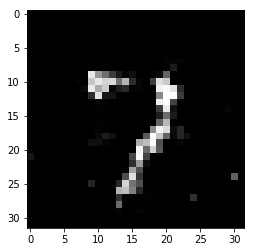

In [37]:
sample = generator(sample_latent_factors(1))[0].numpy().reshape(32,32)
print("Disc prob: {}".format(discriminator(sample.reshape(-1,32,32,1)).numpy()[0][0]))

plt.imshow(
    sample, 
    cmap='gray'
)

## Save the models

In [38]:
# Save
tf.saved_model.save(generator, log_dir + '/saved_generator')
tf.saved_model.save(discriminator, log_dir + '/saved_discriminator')

## Load & use the models

### Generator

In [39]:
# Load
tf_gen = tf.saved_model.load(log_dir + '/saved_generator')

# Serving function
infer_gen = tf_gen.signatures['serving_default']
# Model input
print("Model input: \n\t{}".format(infer_gen.structured_input_signature))
# Model output
print("Model output layer \n\t{}".format(infer_gen.structured_outputs))

# Serving function
generate = lambda x: infer_gen(x)['reshape']

Model input: 
	((), {'input_1': TensorSpec(shape=(None, 100), dtype=tf.float32, name='input_1')})
Model output layer 
	{'reshape': TensorSpec(shape=(None, 32, 32, 1), dtype=tf.float32, name='reshape')}


### Discriminator

In [40]:
# Load
tf_disc = tf.saved_model.load(log_dir + '/saved_discriminator')

# Serving function
infer_disc = tf_disc.signatures['serving_default']
# Model input
print("Model input: \n\t{}".format(infer_disc.structured_input_signature))
# Model output
print("Model output layer \n\t{}".format(infer_disc.structured_outputs))

# Serving function
discriminate = lambda x: infer_disc(x)['F5']

Model input: 
	((), {'input_2': TensorSpec(shape=(None, 32, 32, 1), dtype=tf.float32, name='input_2')})
Model output layer 
	{'F5': TensorSpec(shape=(None, 1), dtype=tf.float32, name='F5')}


### Test

Disc prob: 0.45780590176582336


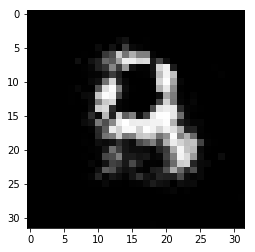

In [41]:
samples = generate(sample_latent_factors(1))

print("Disc prob: {}".format(discriminate(samples).numpy()[0][0]))

plt.imshow(
    samples[0].numpy().reshape(32,32), 
    cmap='gray'
)

In [42]:
# Problem using keras
discriminator.to_json()

AttributeError: 'LeakyReLU' object has no attribute '__name__'

## References

1. <a name="bib-web-gantf"></a>[Building a simple Generative Adversarial Network (GAN) using TensorFlow](https://blog.paperspace.com/implementing-gans-in-tensorflow/)
2. <a name="bib-web-adversarialtf"></a>[Generative Adversarial Nets in TensorFlow](https://wiseodd.github.io/techblog/2016/09/17/gan-tensorflow/)
3. <a name="bib-web-gankeras"></a>[Generative Adversarial Network(GAN) using Keras](https://medium.com/datadriveninvestor/generative-adversarial-network-gan-using-keras-ce1c05cfdfd3)
4. <a name="bib-web-poolstride"></a>[Pooling VS Striding - Striving for Simplicity: The All Convolutional Net](https://arxiv.org/abs/1412.6806)
5. <a name="bib-web-collapse1"></a>[Mode collapse: GAN — Why it is so hard to train Generative Adversarial Networks!](https://medium.com/@jonathan_hui/gan-why-it-is-so-hard-to-train-generative-advisory-networks-819a86b3750b)
6. <a name="bib-web-collapse2"></a>[Mode collapse: What does it mean if all produced images of a GAN look the same?](https://www.quora.com/What-does-it-mean-if-all-produced-images-of-a-GAN-look-the-same)
7. <a name="bib-vid-gans"></a>[NIPS 2016 - Generative Adversarial Networks - Ian Goodfellow](https://www.youtube.com/watch?v=AJVyzd0rqdc)
  1. [On divergence](https://www.youtube.com/watch?v=AJVyzd0rqdc&t=52m10s)
  1. [On labeled/conditioned GANS](https://www.youtube.com/watch?v=AJVyzd0rqdc&t=1h09m50s)
  1. [On mode collapse](https://www.youtube.com/watch?v=AJVyzd0rqdc&t=1h31m53s)
  1. [One sided label smoothing](https://www.youtube.com/watch?v=AJVyzd0rqdc&t=1h11m34s)
  1. [Question: GANs vs VAEs](https://www.youtube.com/watch?v=AJVyzd0rqdc&t=37m10s)
  1. [Question: Sampling distributions uniform VS Norma](https://www.youtube.com/watch?v=AJVyzd0rqdc&t=37m57s)
  1. [Question: mode collapse/same sample](https://www.youtube.com/watch?v=AJVyzd0rqdc&t=35m47s)
8.  <a name="bib-web-tbstarted"></a>[Get started with TensorBoard](https://www.tensorflow.org/tensorboard/r2/get_started#using_tensorboard_with_other_methods)
9. <a name="bib-web-codegan1"></a>[Github: PyTorch-GAN](https://github.com/eriklindernoren/PyTorch-GAN/blob/master/implementations/gan/gan.py)
10. [TQDM (status bar library)](https://tqdm.github.io/)
11. [Inside TensorFlow: Summaries and TensorBoard](https://www.youtube.com/watch?v=OI4cskHUslQ)
 